In [102]:
import datetime as dt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import csv
import itertools
import json
import psaw
import time
from tqdm import tqdm

import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from timeit import default_timer as timer
from pathlib import Path
from calendar import Calendar
import calendar

from collections import defaultdict

In [3]:
# for a, b in tqdm(G.edges):
#     G.edges[a, b]['subreddits'] = set(G.edges[a, b]['subreddits'].split(','))

100%|███████████████████████████████████████████████████| 66385/66385 [00:00<00:00, 217645.65it/s]


In [225]:
def average_pol(G, n, label):
    pols = []
    for _, _, data in G.out_edges(n, data=True):
        pols.append(data[f'avg_{label}_pol'])
    return np.average(pols) if pols else 0

def average_pol_for_label_users(G, pol_label, user_label):
    pol = []
    for n, data in G.nodes(data=True):
        if data['political_label'] == user_label:
            pol.append(average_pol(G, n, pol_label))
    return np.average(pol)

def avg_sub_pol(G, sub, label):
    pols = []
    for _, _, data in G.edges(data=True):
        if sub in data['subreddits']:
            pols.append(data[f'avg_{label}_pol'])
    return np.average(pols)

In [226]:
def get_label(G, user):
    if G.has_node(user):
        return G.nodes[user]['political_label']
    else:
        return None

    
def combine_maps(list_of_dicts, day_included=False):
    dict_of_lists = defaultdict(list)
    for d in list_of_dicts:
        if day_included:
            day, d = d
        for k, v in d.items():
            dict_of_lists[k].append((day, v) if day_included else v)
    return dict_of_lists


def power_user_average_pol(G, label, power_users):
    pols = dict()
    for i, row in power_users.iterrows():
        user = row['author']
        if G.has_node(user):
            pols[user] = average_pol(G, user, label)
    return pols


def sub_average_pol(G, label, subs):
    pols = dict()
    for sub in subs:
        pols[sub] = avg_sub_pol(G, sub, label)
    return pols
    
                           
def day_stats(day, G, users):
    subs = {'AskReddit', 'Conservative', 'Liberal', 'funny', 'gaming', 'pics', 'trees'}
    users = users[users['author'].isin(G.nodes)]
    return {
        'user_lib': (day, power_user_average_pol(G, 'Liberal', users)),
        'sub_lib': (day, sub_average_pol(G, 'Liberal', subs)),
        'user_con': (day, power_user_average_pol(G, 'Conservative', users)),
        'sub_con': (day, sub_average_pol(G, 'Conservative', subs)),
        'baseline_pol': (day, {
            'Conservative': average_pol_for_label_users(G, 'Conservative', 'unaffiliated'),
            'Liberal': average_pol_for_label_users(G, 'Liberal', 'unaffiliated'),
        }),
        'ingroup_pol': (day, {
            'Conservative': average_pol_for_label_users(G, 'Conservative', 'Conservative'),
            'Liberal': average_pol_for_label_users(G, 'Liberal', 'Liberal'),
        }),
    }
    

def all_day_stats():
    stats = []
    users = pd.read_csv('users_09.csv')
    for day in tqdm(range(1, 31)):
        G = nx.readwrite.gexf.read_gexf(f'./data/RC_2012-09_daily_graphs/{day}.gexf')
        stats.append(day_stats(day, G, users))
    return stats

In [227]:
stats = all_day_stats()

100%|█████████████████████████████████████████████████████████████| 30/30 [05:43<00:00, 11.46s/it]


In [ ]:
combined_stats = {k: combine_maps(stat, day_included=True) for k, stat in combine_maps(stats).items()}

In [ ]:
def get_stat_data(combined_stats, stat, subject):
    data = zip(*combined_stats[stat][subject])
    days = next(data)
    values = next(data)
    return days, values

def plot_scores(combined_stats, subject, kind='user'):
    print(f'{subject} Political Scores:')
    con_days, con_values = get_stat_data(combined_stats, f'{kind}_con', subject)
    lib_days, lib_values = get_stat_data(combined_stats, f'{kind}_lib', subject)
    lib_in_days, lib_in = get_stat_data(combined_stats, f'ingroup_pol', 'Liberal')
    con_in_days, con_in = get_stat_data(combined_stats, f'ingroup_pol', 'Conservative')
    lib_base_days, lib_base = get_stat_data(combined_stats, f'baseline_pol', 'Liberal')
    con_base_days, con_base = get_stat_data(combined_stats, f'baseline_pol', 'Conservative')
    
    plt.subplot(1, 2, 1)
    plt.title('r/Conservative')
    plt.xlabel('Day')
    plt.xticks(np.arange(min(con_base_days), max(con_base_days), 3))
    plt.ylabel('Score')
    plt.plot(con_days, con_values, label='actual')
    plt.plot(con_base_days, con_base, '--', label='baseline')
    plt.plot(con_in_days, con_in, '--', label='ingroup')
    plt.plot(con_days, con_values)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title('r/Liberal')
    plt.xlabel('Day')
    plt.xticks(np.arange(min(lib_base_days), max(lib_base_days), 3))
    plt.ylabel('Score')
    plt.plot(lib_days, lib_values, label='actual')
    plt.plot(lib_base_days, lib_base, '--', label='baseline')
    plt.plot(lib_in_days, lib_in, '--', label='ingroup')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_scores(combined_stats, 'Probably_on_Reddit')

In [ ]:
plot_scores(combined_stats, 'AskReddit', kind='sub')

In [207]:
power_users = pd.read_csv('power_users_09.csv')

BlankVerse Political Scores:
ripster55 Political Scores:


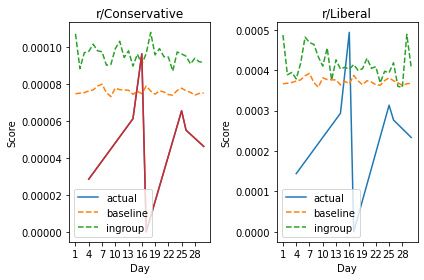

Scopolamina Political Scores:


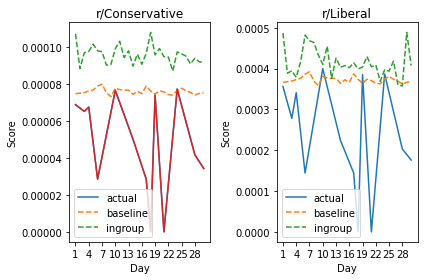

alllie Political Scores:


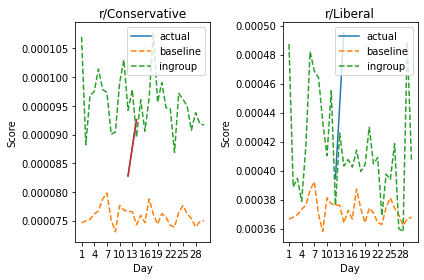

Probably_on_Reddit Political Scores:


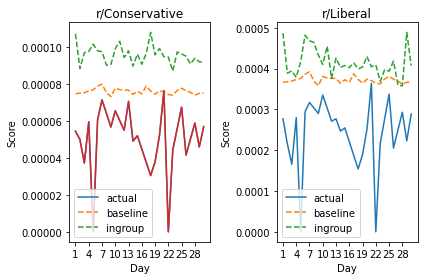

diggro Political Scores:


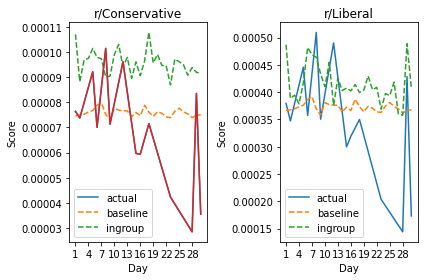

mr_majorly Political Scores:


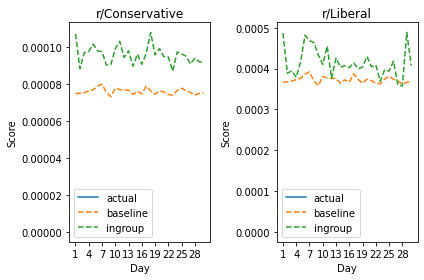

EquanimousMind Political Scores:


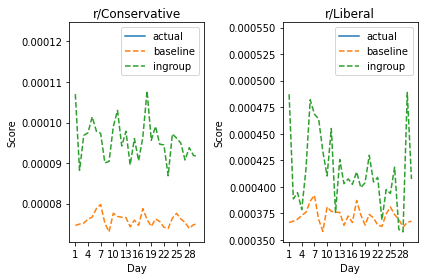

NSFW_PORN_ONLY Political Scores:


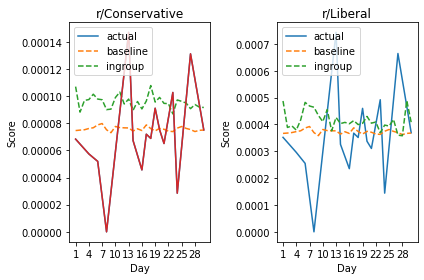

mepper Political Scores:


In [208]:
for power_user in list(power_users[power_users['label'] == 'unaffiliated'].head(10)['user']):
    try:
        plot_scores(combined_stats, power_user)
    except StopIteration:
        pass

In [201]:
def infection_day(max_day, base_days, base_values, in_values, days, values):
    for day in base_days:
        try:
            i = days.index(day)
            if values[i] > in_values[day - 1]:
                return day
        except ValueError:
            pass
    return max_day


def infection_days(combined_stats, max_day, user):
    con_days, con_values = get_stat_data(combined_stats, f'user_con', user)
    lib_days, lib_values = get_stat_data(combined_stats, f'user_lib', user)
    lib_in_days, lib_in = get_stat_data(combined_stats, f'ingroup_pol', 'Liberal')
    con_in_days, con_in = get_stat_data(combined_stats, f'ingroup_pol', 'Conservative')
    lib_base_days, lib_base = get_stat_data(combined_stats, f'baseline_pol', 'Liberal')
    con_base_days, con_base = get_stat_data(combined_stats, f'baseline_pol', 'Conservative')
    lib_inf_day = infection_day(max_day, lib_base_days, lib_base, lib_in, lib_days, lib_values)
    con_inf_day = infection_day(max_day, con_base_days, con_base, con_in, con_days, con_values)
    return lib_inf_day, con_inf_day

In [202]:
for power_user in list(power_users[power_users['label'] == 'unaffiliated'].head(10)['user']):
    try:
        print(f'{power_user}: {infection_days(combined_stats, 31, power_user)}')
    except StopIteration:
        pass

ripster55: (16, 16)
Scopolamina: (31, 31)
alllie: (12, 14)
Probably_on_Reddit: (31, 31)
diggro: (5, 8)
mr_majorly: (31, 31)
EquanimousMind: (15, 15)
NSFW_PORN_ONLY: (13, 13)


In [203]:
users = pd.read_csv('users_09.csv')
users = users.set_index('author')

In [211]:
max_day = 31
for user, row in tqdm(users.iterrows()):
    if row['political_label'] == 'Conservative':
        users.at[user, 'con_inf_day'] = 1
        users.at[user, 'lib_inf_day'] = max_day
    elif row['political_label'] == 'Liberal': 
        users.at[user, 'lib_inf_day'] = 1
        users.at[user, 'con_inf_day'] = max_day
    else:
        try:
            lib_inf_day, con_inf_day = infection_days(combined_stats, max_day, user)
            users.at[user, 'lib_inf_day'] = lib_inf_day
            users.at[user, 'con_inf_day'] = con_inf_day
        except StopIteration:
            users.at[user, 'lib_inf_day'] = max_day
            users.at[user, 'con_inf_day'] = max_day

1085211it [01:17, 13938.86it/s]


In [212]:
users['lib_inf_day'] = users['lib_inf_day'].astype(int)
users['con_inf_day'] = users['con_inf_day'].astype(int)


In [213]:
limited_users = set()
for day in tqdm(range(1, 31)):
    G = nx.readwrite.gexf.read_gexf(f'./data/RC_2012-09_daily_graphs/{day}.gexf')
    limited_users.update(G.nodes)
len(limited_users)

100%|█████████████████████████████████████████████████████████████| 30/30 [02:02<00:00,  4.08s/it]


397213

In [214]:
users

,subreddits,political_label,lib_inf_day,con_inf_day
author,,,,
---,"{'Android', 'AskReddit', 'answers', 'offmyches...",unaffiliated,2,2
----------------,"{'sandiego', 'philadelphia'}",unaffiliated,31,31
----0000----,{'BSD'},unaffiliated,31,31
----ThisIsTheLine---,{'funny'},unaffiliated,31,31
----_----,"{'conspiracy', 'ECE', 'conspiratard', 'skeptic...",unaffiliated,31,31
...,...,...,...,...
zzzzz_,{'Amsterdam'},unaffiliated,31,31
zzzzzamm,{'flying'},unaffiliated,31,31
zzzzzgh,{'worldnews'},unaffiliated,31,31


In [217]:
users[users.index.isin(limited_users)].to_csv('users_09_ground.csv')